<a href="https://colab.research.google.com/github/ydeng-MLM/ECE687_Kaggle_Airbnb_Recommendation/blob/main/RF__ECE687_Airbnb_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Pytorch was used for DNN built, but not enough optimization time 
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import nn

#Results analysis library
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

#Data preparation import
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

#ML algorithms import
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import time

**Data preparation**

In [ ]:
#Reading the data from train.csv
df = pd.read_csv('train.csv')

In [ ]:
#Checking the columns
df.columns

Index(['id', 'Decision', 'Host_response_time', 'Host_is_superhost',
       'Host_has_profile_pic', 'Host_identity_verified', 'Neighbourhood',
       'Property_type', 'Room_type', 'Accommodates', 'Bathrooms_text',
       'Bedrooms', 'Beds', 'Essentials', 'Cooking', 'Balcony', 'Parking',
       'Price', 'Number_of_reviews', 'Review_scores_rating',
       'Instant_bookable', 'Month'],
      dtype='object')

In [ ]:
#Print out all the NaN entry
df.columns[df.isnull().any()].tolist()

['Host_response_time',
 'Host_is_superhost',
 'Host_has_profile_pic',
 'Host_identity_verified',
 'Bedrooms',
 'Beds',
 'Review_scores_rating']

In [ ]:
#Cleaning all the NaN entry
df['Host_response_time'].fillna("No response", inplace = True)
df['Host_is_superhost'].fillna("t", inplace = True)
df['Host_has_profile_pic'].fillna("t", inplace = True)
df['Host_identity_verified'].fillna("t", inplace = True)
df['Bedrooms'].fillna(1, inplace = True)
df['Beds'].fillna(1, inplace = True)
review_mean = df['Review_scores_rating'].mean()
df['Review_scores_rating'].fillna(review_mean, inplace = True)

df['Price'] = df['Price'].str.replace(',', '')
df['Price'] = df['Price'].str.replace('$', '')
df['Price'] = df['Price'].astype(float)


In [ ]:
#Use column transformer to define specific encoders for each column in the dataframe
column_trans = make_column_transformer((OneHotEncoder(drop='if_binary'),
                                        ['Host_is_superhost', 'Host_has_profile_pic', 'Host_identity_verified',
                                         'Instant_bookable']),
                                      (OrdinalEncoder(), ['Host_response_time', 'Neighbourhood', 'Property_type',
                                                          'Room_type', 'Bathrooms_text', 'Essentials', 
                                                          'Month']),
                                      remainder='passthrough')

In [ ]:
#Defining the label from the dataframe
labels = df.to_numpy()[:, 1].astype('float32')

#Encoder is defined here wth the column transformer
enc = column_trans.fit(df.drop(columns=['id', 'Decision']))
#Features now is encoded by the encoder
features = enc.transform(df.drop(columns=['id', 'Decision']))

#Defining the scaler and fit on the dataset
scaler = StandardScaler()
#scaler = RobustScaler()
scaler.fit(features)
#The features are now standarized by the standard scaler
features = scaler.transform(features)

**Train/Test set Split**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.1, random_state=42)

print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (6723, 20) (6723,)
Test (748, 20) (748,)


**Random search**

In [ ]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_features = ['auto', 'sqrt']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 5, 10]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 10]}


In [ ]:
#Random searching first to identify a good hyperparmeters range
clf = RandomForestClassifier()
# Random search with 5 fold cross validation, 
clf_random = RandomizedSearchCV(estimator = clf, param_distributions=random_grid, n_iter=100, cv=5, verbose=2, random_state=42, n_jobs=-1)
# Fit the random search model
clf_random.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 5, 10],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [ ]:
clf_random.best_params_

{'max_depth': 20,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

**Fine grid search**

In [ ]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [10, 20, 30, 40],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [1000, 1100, 1200, 1300]
}
# Create a based model
clf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)

In [ ]:
grid_search.fit(X_train, y_train)
grid_search.best_params_

Fitting 5 folds for each of 108 candidates, totalling 540 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
180 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
180 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-p

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 1300}

**Optimized model cross validation/test set performance**

In [ ]:
clf = RandomForestClassifier(n_estimators=1000, max_depth=30, max_features='sqrt', min_samples_split=3)
#10-fold KFold method for cross-validations 
cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean()

0.8106494993985706

In [ ]:
time_arr = []
for i in range(10):
  start = time.time()
  clf.fit(X_train, y_train)
  end = time.time()
  time_arr.append(end - start)

print(np.mean(time_arr))

11.672647762298585


In [ ]:
clf.fit(X_train, y_train)

#Report final performance on test set
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

11.71853756904602
              precision    recall  f1-score   support

         0.0       0.79      0.69      0.73       256
         1.0       0.85      0.90      0.88       492

    accuracy                           0.83       748
   macro avg       0.82      0.80      0.80       748
weighted avg       0.83      0.83      0.83       748



Text(0, 0.5, 'Accuracy')

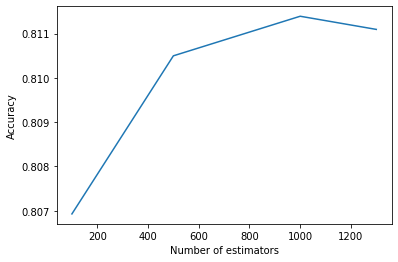

In [ ]:
accs = []

n_es_arr = [100, 500, 1000, 1300]
for n_estimators in n_es_arr:
  clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=30, max_features='sqrt', min_samples_split=3)
  acc = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean()
  accs.append(acc)


plt.plot(n_es_arr, accs)
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')

In [ ]:
df_test = pd.read_csv('test.csv')

#Cleaning all the NaN entry

#df.columns[df.isna().any()].tolist()
df_test.columns[df_test.isnull().any()].tolist()


df_test['Host_response_time'].fillna("No response", inplace = True)
df_test['Host_is_superhost'].fillna("t", inplace = True)
df_test['Host_has_profile_pic'].fillna("t", inplace = True)
df_test['Host_identity_verified'].fillna("t", inplace = True)
df_test['Bedrooms'].fillna(1, inplace = True)
df_test['Beds'].fillna(1, inplace = True)
df_test['Review_scores_rating'].fillna(review_mean, inplace = True)

df_test['Price'] = df_test['Price'].str.replace(',', '')
df_test['Price'] = df_test['Price'].str.replace('$', '')
df_test['Price'] = df_test['Price'].astype(float)



df_test = df_test.replace('Entire serviced apartment', 'Entire apartment')
df_test = df_test.replace('Hut', 'Entire residential home')
df_test = df_test.replace('Private room in loft', 'Private room in apartment')
df_test = df_test.replace('7.5 baths', '3 baths')


test_features = enc.transform(df_test.drop(columns=['id']))

test_features = scaler.transform(test_features)

print(np.mean(test_features[:, 0]), np.std(test_features[:, 0]))

-0.19272656614965167 1.0847086140890212


In [ ]:
acc_test = clf.predict(test_features)

print(acc_test.shape)

(2440,)


In [ ]:
id = np.arange(len(acc_test))+1

print(id)

save_arr = np.vstack((id, acc_test)).T

print(save_arr.shape)

np.savetxt("RF_120921.csv", save_arr, fmt='%i', delimiter=",", header="id,Decision", comments='')

[   1    2    3 ... 2438 2439 2440]
(2440, 2)
